# Match Images of the Sun Surface

Lets start by opening the fits files and look at their content.

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

# load images
iris = fits.open('iris_l2_20161012_144321_3600258819_SJI_2832_t000.fits')
rosa = fits.open('ROSA_Continuum4170_20161012_145601.842.fits')

iris.info()
rosa.info()

Filename: iris_l2_20161012_144321_3600258819_SJI_2832_t000.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     161   (386, 402, 121)   int16 (rescales to float32)   
  1              ImageHDU        38   (31, 121)   float64   
  2              TableHDU        33   121R x 5C   [A10, A10, A3, A66, A59]   
Filename: ROSA_Continuum4170_20161012_145601.842.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      40   (1004, 1002)   float32   


Load image data from fits objects and close fits file. The rosa image needs to be inverted on the x axis and rotated by 90 degree.

In [74]:
img_iris = iris[0].data[20, :, :]
img_rosa = rosa[0].data

# invert x axis and rotate
img_rosa = np.rot90(img_rosa)
img_rosa = np.flip(img_rosa, 1)

378.149


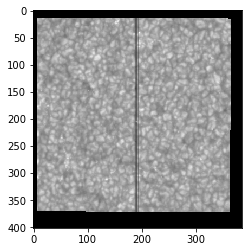

In [3]:
plt.imshow(img_iris, cmap='gray')
print(img_iris.mean())

1.02294


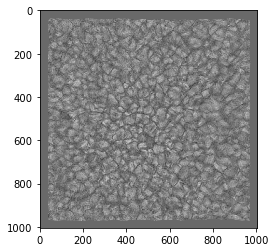

In [4]:
plt.imshow(img_rosa, cmap='gray')
print(img_rosa.mean())

## Preprocessing

The black area around the iris image should not be part of the image so we set them to nan. The area in the rosa image, that is actually not part of the image can be cropped. Also the image live in very different value levels, so we have to normalize them.

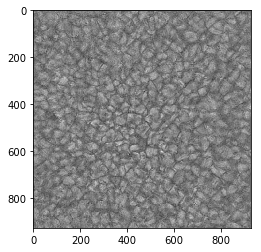

In [109]:
plt.imshow(img_rosa, cmap='gray')

In [110]:
img_iris[img_iris < 0] = np.nan

img_iris_n = img_iris - img_iris[~np.isnan(img_iris)].min()
img_iris_n *= 255. / img_iris_n[~np.isnan(img_iris)].max()

img_rosa_n = img_rosa[38:965, 40:968] - img_rosa[38:965, 40:968].min()
img_rosa_n *= 255. / img_rosa_n.max()

img_iris_n = np.asarray(img_iris_n, dtype=np.uint8)
img_rosa_n = np.asarray(img_rosa_n, dtype=np.uint8)

print('normalized iris mean: ', img_iris_n[~np.isnan(img_iris)].mean())
print('normalized rosa mean: ', img_rosa_n.mean())

normalized iris mean:  131.017823427
normalized rosa mean:  124.618412426


/home/dutchman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


Both images show roughly the same area of the sun and are very close in time. There is one darker spot that can be seen on both images. In order to see how the two images can be matched we try to isolate that dark spot in the iris image before we can look for it in the rosa image.

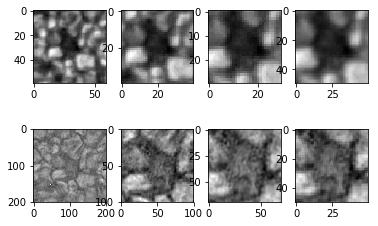

In [126]:
from scipy.misc import imresize

f, ax = plt.subplots(2, 4)
ax[0, 0].imshow(img_iris_n[155:215, 205:265], cmap='gray')
ax[0, 1].imshow(img_iris_n[165:205, 215:255], cmap='gray')
ax[0, 2].imshow(img_iris_n[170:200, 220:250], cmap='gray')
ax[1, 0].imshow(img_rosa_n[462:662, 360:560], cmap='gray')
ax[1, 1].imshow(img_rosa_n[512:612, 410:510], cmap='gray')
ax[1, 2].imshow(img_rosa_n[532:602, 430:500], cmap='gray')

darkspot = imresize(img_iris_n[170:200, 220:250], (50, 50)) # imresize sucks donkey balls
darkspot_ref = imresize(img_rosa_n[532:602, 430:500], (50, 50))

ax[0, 3].imshow(darkspot, cmap='gray')
ax[1, 3].imshow(darkspot_ref, cmap='gray')

## Features

In the next step we extract patches from the rosa image. Even though we can guess where the dark spot should be we act as if we dont. That is why we compute a patch for every pixel. We extract the rosa patches with a larger size because of the finer resolution and upsample the iris patch. However we dont know the exact resolution difference so instead we just upsample the patch to the same size. If the resolution difference is small it should still work, otherwise it would be clever to downsample before taking patches. Note this operation needs a lot of memory (about 10GB on our machine), so if you dont have that much memory you can crop the image.

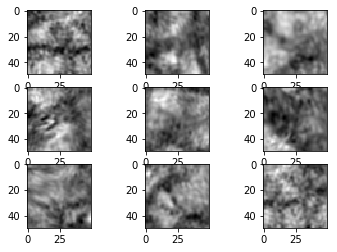

In [127]:
from sklearn.feature_extraction import image
patches = image.extract_patches_2d(img_rosa_n, (50, 50))

f, ax = plt.subplots(3, 3)
ax[0, 0].imshow(patches[len(patches)//2], cmap='gray')
ax[1, 0].imshow(patches[len(patches)//2 + 100], cmap='gray')
ax[2, 0].imshow(patches[len(patches)//2 + 200], cmap='gray')
ax[0, 1].imshow(patches[len(patches)//2 + 300], cmap='gray')
ax[1, 1].imshow(patches[len(patches)//2 + 400], cmap='gray')
ax[2, 1].imshow(patches[len(patches)//2 + 600], cmap='gray')
ax[0, 2].imshow(patches[len(patches)//2 + 700], cmap='gray')
ax[1, 2].imshow(patches[len(patches)//2 + 800], cmap='gray')
ax[2, 2].imshow(patches[len(patches)//2 + 900], cmap='gray')


In [128]:
distances = np.array([np.sqrt(np.sum((patches[x] - darkspot) ** 2)) for x in range(patches.shape[0])])

Dist argmin:  453.679402221
Dist ref:  482.897504653
Mean dist:  500.164750981


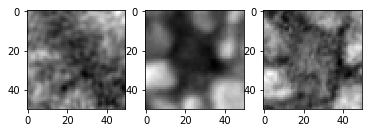

In [133]:
f, ax = plt.subplots(1, 3)

ax[0].imshow(patches[distances.argmin()], cmap='gray')
ax[1].imshow(darkspot, cmap='gray')
ax[2].imshow(darkspot_ref, cmap='gray')

print('Dist argmin: ', np.sqrt(np.sum((patches[distances.argmin()] - darkspot) ** 2)))
print('Dist ref: ', np.sqrt(np.sum((darkspot_ref - darkspot) ** 2)))
print('Mean dist: ', distances.mean())

In [155]:
len(distances[distances < 482.9])

23753

(array([  1.00000000e+00,   4.00000000e+00,   1.00000000e+00,
          6.00000000e+00,   1.30000000e+01,   2.40000000e+01,
          4.50000000e+01,   8.90000000e+01,   1.63000000e+02,
          2.53000000e+02,   4.45000000e+02,   6.71000000e+02,
          1.02300000e+03,   1.55700000e+03,   2.21000000e+03,
          3.37300000e+03,   4.74100000e+03,   6.48000000e+03,
          8.46900000e+03,   1.15180000e+04,   1.51110000e+04,
          1.90870000e+04,   2.40180000e+04,   2.92580000e+04,
          3.46020000e+04,   4.06490000e+04,   4.59860000e+04,
          5.12350000e+04,   5.49000000e+04,   5.78920000e+04,
          5.77570000e+04,   5.62210000e+04,   5.25490000e+04,
          4.68170000e+04,   3.95650000e+04,   3.23740000e+04,
          2.45360000e+04,   1.79020000e+04,   1.22830000e+04,
          7.80400000e+03,   4.75000000e+03,   2.70800000e+03,
          1.42300000e+03,   7.41000000e+02,   3.23000000e+02,
          1.15000000e+02,   4.50000000e+01,   1.90000000e+01,
        

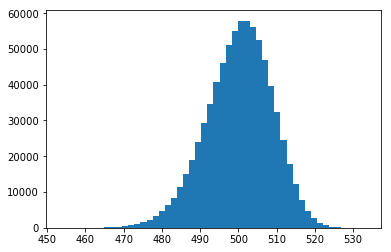

In [151]:
plt.hist(distances, bins=50)